# NEW NETWORK

## Goal : 
The goal of this network is to group every user we got from the scrapped tweets and their friends (e.g people they are following) and go through different step to show :
* What kind of connection they share (bipartite or small world)
* If they follow the same people or not ? What does that mean ?
* Do they belong to the same community ? 

## Things to use : 
### Directed Graph
* Basic stats : What is the total number of nodes in the network? What is the total number of links? What's the average degree? What's the median degree?
* List the top 10 account by in-degree and out-degree. What is the interpretation of in-degree and out-degree in this case?
* Plot the distribution of in-degrees and out-degrees, binned using numpy.histogram. What is the most common degree?
* Plot the distribution of in-degrees and out-degrees one more time, this time plotted loglog scale.
* Describe the distributions (as you would in a well written figure caption). Do they look Poissonian? Power-law? Something in between?
* Plot a scatter plot of the the in- versus out- degree for all accounts using a loglog scale. Comment on the relation between the two.

### Undirected Graph

* Find the 5 most central accounts according to betweenness centrality. What role these accounts with high graph betweenness centrality play ?
* Find the 5 most central accounts according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
* Is the undirected version of the graph assortative with respect do degree? (e.g. do high-degree accounts tend to link to other high-degree accounts, and low-degree accounts to other low-degree accounts?). Interpreation ?

### Community

* Maybe do two branches : democrats/republicans
* Use the Python Louvain-algorithm implementation to find communities in the full network. Report the value of modularity found by the algorithm. 

### Bubble world / Small world
* Inspect how people connect to each other, is the small world hypothesis confirmed ? Is the bubble world hyposthesis confirmed ?

In [9]:
from twitter import *

In [18]:
CONSUMER_KEY = 'CONSUMER_KEY'
CONSUMER_SECRET = 'CONSUMER_SECRET'
OAUTH_TOKEN = 'OAUTH_TOKEN'
OAUTH_TOKEN_SECRET = 'OAUTH_TOKEN_SECRET'

In [ ]:
# load our API credentials 
twitter = Twitter(
    auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET))

In [10]:
import tweepy

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth)

## Get the users from Mongo DB

In [1]:
import pymongo, pprint
from pymongo import MongoClient

In [2]:
properties = dict(line.strip().split('=') 
          for line in open('db.properties')
          if not line.startswith('#') and not line.startswith('\n'))

In [3]:
uri = 'mongodb://%s:%s@ds161487.mlab.com:61487/election_tweets' % (properties['username'], properties['password'])
client = MongoClient(uri)

In [4]:
db = client.election_tweets
tweet_collection = db.tweets
user_collection = db.users

In [ ]:
print user_collection.count()

## Create the network

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
directed = nx.DiGraph()

In [7]:
users = user_collection.find()

In [11]:
for i in users:
    #select the user name
    user = api.get_user(i["_id"])
    username = user.screen_name

    # perform a basic search 
    query = twitter.friends.ids(screen_name = username)
    print "found %d friends" % (len(query["ids"]))
    
    # now we loop through them to pull out more info, in blocks of 100.
    for n in range(0, len(query["ids"]), 100):
        ids = query["ids"][n:n+100]

        # create a subquery, looking up information about these users
        subquery = twitter.users.lookup(user_id = ids)

        for user_q in subquery:
            # now print out user info, starring any users that are Verified.
            directed.add_node(user_q["screen_name"])
            directed.add_edge(username, user_q["screen_name"])
            #print " [%s] %s" % ("*" if user["verified"] else " ", user["screen_name"])

found 255 friends
found 165 friends
found 430 friends
found 911 friends
found 165 friends
found 5000 friends
found 251 friends
found 1262 friends
found 194 friends
found 647 friends
found 397 friends
found 162 friends
found 5000 friends
found 319 friends
found 21 friends


TwitterHTTPError: Twitter sent status 429 for URL: 1.1/friends/ids.json using parameters: (oauth_consumer_key=UAclDqCOIjWcR18OM33tFpUko&oauth_nonce=7770918518461879757&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1479932813&oauth_token=771302832909746176-lkfIU5F9uWRwwfnR7XiDlY5b1cOoAoe&oauth_version=1.0&screen_name=SultryRobin&oauth_signature=IAPeAMXxGsO4p8m%2BWevgcGal6MU%3D)
details: {u'errors': [{u'message': u'Rate limit exceeded', u'code': 88}]}

In [19]:
#Plot the network and scale the nodes size on degree

d = nx.degree(directed)

** Draw is way too expensive, I have to find something else **

In [ ]:


#nx.draw(directed, nodelist=d.keys(), node_size=[v * 100 for v in d.values()])
#plt.show()

## Basic Stats

In [20]:
import numpy as np
%matplotlib inline 

In [31]:
#Number of node
print "The graph has %d nodes" % directed.number_of_nodes() , "and and %d edges "% directed.number_of_edges()

#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed.in_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed.out_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)

print node_in_degree_tuples[:10]
print node_out_degree_tuples[:10]




The graph has 9105 nodes and and 9683 edges 
[(u'RealBenCarson', 7), (u'DonaldJTrumpJr', 6), (u'realDonaldTrump', 6), (u'mike_pence', 6), (u'KellyannePolls', 5), (u'SheriffClarke', 5), (u'AnnCoulter', 5), (u'LouDobbs', 5), (u'FoxNews', 5), (u'JudgeJeanine', 5)]
[(u'bad_bad_bernie', 2979), (u'ConstanceQueen8', 2125), (u'kurteichenwald', 1196), (u'BJLife', 884), (u'AnnCoulter', 564), (u'FoxNews', 400), (u'dash_german', 348), (u'Ethan_Booker', 243), (u'Di_AngeloT', 207), (u'duckiller01', 172)]


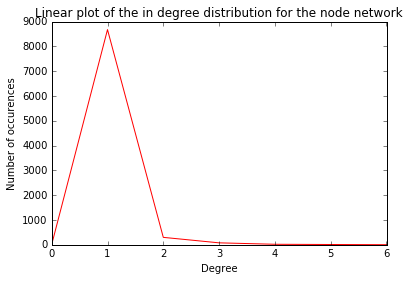

In [32]:
#Distributions
# Compute min and max values for the degrees
node_in_degree = map(lambda x: x[1], node_in_degree_tuples)
node_out_degree = map(lambda x: x[1], node_out_degree_tuples)
max_in_degree = max(node_in_degree)
min_in_degree = min(node_in_degree)
max_out_degree = max(node_out_degree)
min_out_degree = min(node_out_degree)

# Compute the bins for our degree distribution
bins_in = [i for i in range(min_in_degree, max_in_degree+1)]
bins_out = [i for i in range(min_out_degree, max_out_degree+1)]

degrees_in_hist, degrees_in_bin = np.histogram(node_in_degree, bins=bins_in)
degrees_out_hist, degrees_out_bin = np.histogram(node_out_degree, bins=bins_out)

plt.plot(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the in degree distribution for the node network')
plt.show()

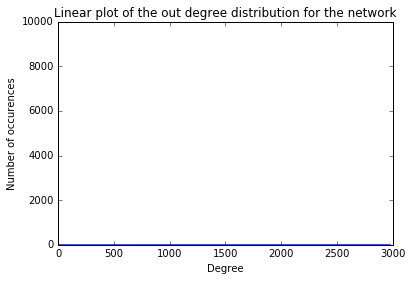

In [33]:
plt.plot(degrees_out_bin[:-1], degrees_out_hist, 'b')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the out degree distribution for the network')
plt.show()

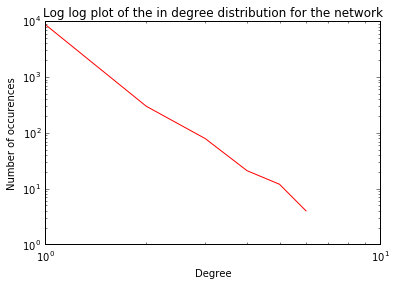

In [34]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the in degree distribution for the network')
plt.show()

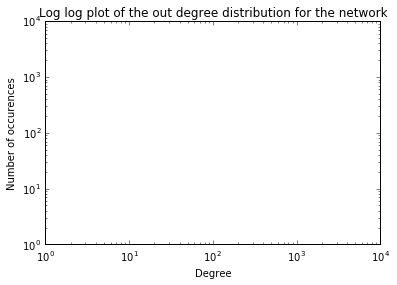

In [35]:


plt.loglog(degrees_out_bin[:-1], degrees_out_hist)
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the out degree distribution for the network')
plt.show()



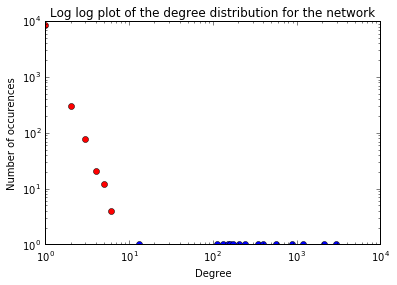

In [36]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'ro')
plt.loglog(degrees_out_bin[:-1], degrees_out_hist, 'o')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the degree distribution for the network')
plt.show()

## Centrality and other stuffs

In [29]:
undir = directed.to_undirected()

** Calculating the centrality takes ages, I'll do an approx later **

In [ ]:
between_centrality = nx.betweenness_centrality(undir)
between_centrality_sorted = sorted(between_centrality.iteritems(), key=lambda (name, value): -value)

print "Betweenes : The 5 most central accounts are :\n" 
print between_centrality_sorted[:5]